<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e5/Logo_%C3%A9cole_des_ponts_paristech.svg/676px-Logo_%C3%A9cole_des_ponts_paristech.svg.png" width="200"  height="200" hspace="200"/> </td>
<td> <img src="https://pbs.twimg.com/profile_images/1156541928193896448/5ihYIbCQ_200x200.png" width="200" height="200" /> </td>
</tr></table>

<br/>

<h1><center>Session 7 - Model Evaluation and Selection</center></h1>



<font size="3">This session is divided into **2** parts:
- **Model selection**
- **Model optimization:**
>  * 1-Features selection
>  * 2-Hyperparameters optimization

In each of these parts, some **guidelines** and **hints** are given for each task. 
Do not hesitate to check the links to documentation to understand the functions you use. 
    
The goal of this session is to **select a model** that you will use as your best candidate and optimize it to get the best out of it.
</font>

# Session 5 modelling wrap up 

In [1]:
#basics
import pandas as pd
import numpy as np

#processing
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics._regression import _check_reg_targets

#models
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
def load_dataset(path):
    print(f"loading raw data..")
    data = pd.read_csv(path)
    return data

def clean_data(data, drop_2020=True):
    print(f"cleaning data..")
    data = data.dropna()
    if drop_2020:
        data = data.query("year != 2020")
    data = data.sort_values(by='release_date')
    data.release_date = pd.to_datetime(data.release_date)
    data.index = data.release_date
    data = data.drop(columns = ['index', 'release_date', 'year'], errors='ignore')
    return data

def train_test_split_by_date(df: pd.DataFrame, split_date: str):
    """Split dataset according to a split date in format "YYYY-MM-DD"
    - train: [:split_date[
    - test: [split_date:]
    """
    train = df.loc[:split_date].copy()
    test = df.loc[split_date:].copy()
    return train, test

def get_x_y(dataset):
    target = dataset.sales
    target = target.astype(float)
    features = dataset.drop(columns = ['sales'], errors='ignore')
    return features, target
          
def transform_target(target, forward = True):
    if forward == True: target_tf = [np.log(x) for x in target]
    else: target_tf = [np.exp(x) for x in target]
    return target_tf  
          
def get_evaluation_metrics(y_test, y_pred, y_train=None) -> dict:
    metrics = {
        'mape': mean_absolute_percentage_error(y_test, y_pred),
        'rmse': mean_squared_error(y_test, y_pred, squared=False),
        'mae': mean_absolute_error(y_test, y_pred),
    }
    return metrics

def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def prettify_metrics(metrics: dict) -> str:
    output = [f"Evaluation:\n{'-'*10}"]
    for name, metric in metrics.items():
        output.append((f'- {name.upper()}: {round(metric, 2)}'))
    return '\n'.join(output) +'\n'

def train(lr, features, target, transformer = None):
    print(f"start fitting a {lr.__class__}...")
    if transformer:
        lr = lr.fit(features, transformer(target, forward = True))
    predicted_target = lr.predict(features)
    if transformer:
        predicted_target = transformer(predicted_target, forward= False)
    print(prettify_metrics(get_evaluation_metrics(target, predicted_target)))
    
    return lr

def evaluate(lr, features, target, transformer=None, ret=False):
    predicted_target = lr.predict(features)
    if transformer:
        predicted_target = transformer(predicted_target, forward= False)
    
    print(prettify_metrics(get_evaluation_metrics(target, predicted_target)))
    if ret==True:
        return get_evaluation_metrics(target, predicted_target)

# Model Selection

## Q1 - Train/Test --> Train/Validation/Test

#### What if we want to use 2020 as testing set ?
Update the split function so that we can keep 2020 as testing set
> -  Modify the function **train_test_split_date** to produce a **train_validation_test_split_date**
> -  Hint: add another date split to the function or use the function twice
> - Your function should return 3 datasets

In [3]:
def train_test_split_by_date(df: pd.DataFrame, split_date_val: str, split_date_test: str):
    """Split dataset according to a split date in format "YYYY-MM-DD"
    - train: [:split_date_1[
    - validation: [split_date_1: split_date_2[
    - test: [split_date_2:[
    """
    train = df.loc[:split_date_val].copy()
    validation = df.loc[split_date_val:split_date_test].copy()
    test = df.loc[split_date_test:].copy()
    return train, validation, test

## Model training

In [4]:
path = '/Users/yaguethiam/Ponts/data_prepared_ponts_v4.csv'
raw_data = load_dataset(path)

loading raw data..


In [15]:
data = clean_data(raw_data, drop_2020=False)
train_data, validation_data, test_data = train_test_split_by_date(data,
                                                                  '2018-01-01',
                                                                  '2020-01-01')
train_x, train_y = get_x_y(train_data)
validation_x, validation_y = get_x_y(validation_data)
test_x, test_y = get_x_y(test_data)

cleaning data..


# Models training
> - run a linear regression, a Random Forest and a LGBM on the dataset without testing
> - what metrics is more representative for our problem?
> - compare the models
> - select the best model

#### Linear regression

In [7]:
lr = LinearRegression()
lr = train(lr, train_x, train_y, transformer = transform_target)
print("Evaluate on validation set ...")
evaluate(lr, validation_x, validation_y, transformer = transform_target)

start fitting a <class 'sklearn.linear_model._base.LinearRegression'>...
Evaluation:
----------
- MAPE: 530.3
- RMSE: 641453.04
- MAE: 156706.79

Evaluate on validation set ...
Evaluation:
----------
- MAPE: 469.75
- RMSE: 1458913.78
- MAE: 191188.52



#### Random Forest 

In [8]:
rf = RandomForestRegressor()
rf = train(rf, train_x, train_y, transformer = transform_target)
print("Evaluate on validation set ...")
evaluate(rf, validation_x, validation_y, transformer = transform_target)

start fitting a <class 'sklearn.ensemble._forest.RandomForestRegressor'>...
Evaluation:
----------
- MAPE: 46.16
- RMSE: 163213.62
- MAE: 62127.64

Evaluate on validation set ...
Evaluation:
----------
- MAPE: 443.92
- RMSE: 245229.08
- MAE: 108568.69



#### LGBM Regressor

In [9]:
lgbm = LGBMRegressor()
lgbm = train(lgbm, train_x, train_y, transformer = transform_target)
print("Evaluate on validation set ...")
evaluate(lgbm, validation_x, validation_y, transformer = transform_target)

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 163.14
- RMSE: 222880.43
- MAE: 97888.22

Evaluate on validation set ...
Evaluation:
----------
- MAPE: 402.64
- RMSE: 247929.68
- MAE: 107553.21



## What are your thoughts?
> - What can you say about the performance of the different model on the 2 datasets?
> - Which model is overfitting ?
> - Which model is underfitting?
> - Which model is the best?

The linear regression seems to be underfitting because the train error is bigger than the validation error. Maybe it is to sipmplistic.
The random forest has great performance on the training set but get very bad on validation set, you dont want to select this model to run in prod. It might be overfitting too.

Although the LGBM seems to be overfitting too, it has better performance on the validation set and the performance seems to be decrease less between training and validation. So we will pick that model as our procedure advice it.

### Train the selected model, validate and test

In [10]:
lgbm = LGBMRegressor()
lgbm = train(lgbm, train_x, train_y, transformer = transform_target)
print("Evaluate on validation set ...")
evaluate(lgbm, validation_x, validation_y, transformer = transform_target)

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 163.14
- RMSE: 222880.43
- MAE: 97888.22

Evaluate on validation set ...
Evaluation:
----------
- MAPE: 402.64
- RMSE: 247929.68
- MAE: 107553.21



In [16]:
print("Evaluate on test set ...")
evaluate(lgbm, test_x, test_y, transformer = transform_target)

Evaluate on test set ...
Evaluation:
----------
- MAPE: 242.21
- RMSE: 107999.79
- MAE: 60957.63



# Model Optimization

> From this step and forward we will only focus on the MAPE to monitor the performance of our model

In [19]:
def get_evaluation_metrics(y_test, y_pred, y_train=None) -> dict:
    metrics = {
        'mape': mean_absolute_percentage_error(y_test, y_pred)
    }
    return metrics

## 1 - Features selection : Importance Based

In [20]:
#save the importance in a dataframe in descending order (from most important to less important
#plot the feature importance for the selected model 
lgbm_feature_imp = pd.DataFrame(lgbm.feature_importances_, train_x.columns, columns=['importance'])
lgbm_feature_imp = lgbm_feature_imp.sort_values(by='importance', ascending=False)


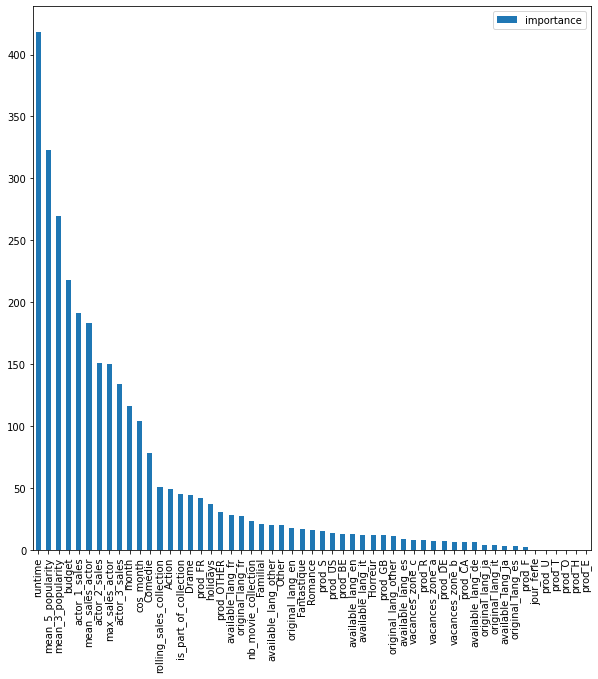

In [21]:
lgbm_feature_imp.plot(kind='bar', figsize=(10,10))

In [22]:
# Loop on all features from 1 to n and keep track of the MAPE
mape = []
features_number = []
for k in range(1, lgbm_feature_imp.shape[0]):
    train_k = train_x[lgbm_feature_imp[:k].index]
    validation_k = validation_x[lgbm_feature_imp[:k].index]
    learner = train(LGBMRegressor(), train_k, train_y, transformer = transform_target)
    metrics = evaluate(learner, validation_k, validation_y, transformer = transform_target, ret=True)
    features_number.append(k)
    mape.append(metrics['mape']) 

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 688.75

Evaluation:
----------
- MAPE: 952.81

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 461.94

Evaluation:
----------
- MAPE: 707.03

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 401.66

Evaluation:
----------
- MAPE: 760.54

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 307.13

Evaluation:
----------
- MAPE: 631.7

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 267.68

Evaluation:
----------
- MAPE: 577.71

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 229.1

Evaluation:
----------
- MAPE: 630.53

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 228.54

Evaluation:
----------
- MAPE: 659.07

start fitting a <class 'lightgbm.skl

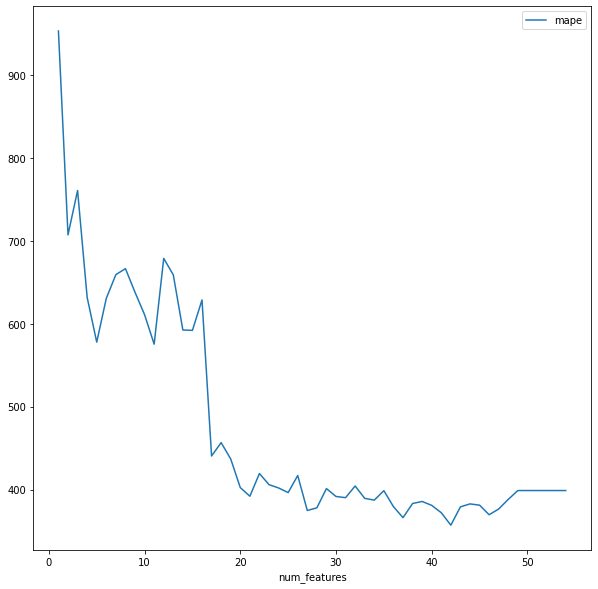

In [23]:
#plot MAPE vs number of features 
#what do you observe
results = pd.DataFrame({'num_features':features_number,
              "mape": mape})

results.index = results.num_features
results.drop('num_features', axis=1, inplace=True)
results.plot(figsize=(10,10))

In [25]:
# What is the top k features given the MAPE on the validation set?
best_k = np.argmin(mape)
best_k

41

In [31]:
#Run the model with the K best features and check the results
lgbm = LGBMRegressor()
lgbm = train(lgbm, train_x[lgbm_feature_imp[:best_k+1].index], train_y, transformer = transform_target)
print("Evaluate on validation set ...")
evaluate(lgbm, validation_x[lgbm_feature_imp[:best_k+1].index], validation_y, transformer = transform_target)

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 163.38

Evaluate on validation set ...
Evaluation:
----------
- MAPE: 357.02



In [32]:
print("Evaluate on test set ...")
evaluate(lgbm, test_x[lgbm_feature_imp[:best_k+1].index], test_y, transformer = transform_target)

Evaluate on test set ...
Evaluation:
----------
- MAPE: 258.24



## 2 - Select the best Hyperparameters

In this part we will implement the grid search hyperparameter algorithm from scratch

#### Grid Search from scratch

In [33]:
from sklearn.model_selection import ParameterGrid
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html

In [34]:
#print lgbm parameters
#hint place your cursor after the dot and hit tab
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [51]:
param_grid = {'n_estimators': [80, 90, 100, 110, 120],
              'num_leaves': [27, 31, 35]}

In [52]:
#use ParameterGrid to print all the combinations of hyperparameters
list(ParameterGrid(param_grid))

[{'n_estimators': 80, 'num_leaves': 27},
 {'n_estimators': 80, 'num_leaves': 31},
 {'n_estimators': 80, 'num_leaves': 35},
 {'n_estimators': 90, 'num_leaves': 27},
 {'n_estimators': 90, 'num_leaves': 31},
 {'n_estimators': 90, 'num_leaves': 35},
 {'n_estimators': 100, 'num_leaves': 27},
 {'n_estimators': 100, 'num_leaves': 31},
 {'n_estimators': 100, 'num_leaves': 35},
 {'n_estimators': 110, 'num_leaves': 27},
 {'n_estimators': 110, 'num_leaves': 31},
 {'n_estimators': 110, 'num_leaves': 35},
 {'n_estimators': 120, 'num_leaves': 27},
 {'n_estimators': 120, 'num_leaves': 31},
 {'n_estimators': 120, 'num_leaves': 35}]

In [53]:
## loop into this list of hyperparameters and get the best subset by logging MAPE
mape_gs = []
parameters = []
for params in list(ParameterGrid(param_grid)):
    learner = train(LGBMRegressor(**params), train_x[lgbm_feature_imp[:best_k+1].index], train_y, transformer = transform_target)
    metrics = evaluate(learner, validation_x[lgbm_feature_imp[:best_k+1].index], validation_y, transformer = transform_target, ret=True)
    parameters.append(params)
    mape_gs.append(metrics['mape']) 

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 204.92

Evaluation:
----------
- MAPE: 383.1

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 182.22

Evaluation:
----------
- MAPE: 362.2

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 170.05

Evaluation:
----------
- MAPE: 387.1

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 194.4

Evaluation:
----------
- MAPE: 380.48

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 172.04

Evaluation:
----------
- MAPE: 359.55

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 159.33

Evaluation:
----------
- MAPE: 384.85

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 180.59

Evaluation:
----------
- MAPE: 379.92

start fitting a <class 'lightgbm.sklea

In [54]:
# what is the best set of parameters
parameters[np.argmin(mape_gs)]

{'n_estimators': 100, 'num_leaves': 31}

In [50]:
# Run a model with the best set of features 
#Run the model with the K best features and check the results
lgbm = LGBMRegressor(**parameters[np.argmin(mape_gs)])
lgbm = train(lgbm, train_x[lgbm_feature_imp[:best_k+1].index], train_y, transformer = transform_target)
print("Evaluate on validation set ...")
evaluate(lgbm, validation_x[lgbm_feature_imp[:best_k+1].index], validation_y, transformer = transform_target)

start fitting a <class 'lightgbm.sklearn.LGBMRegressor'>...
Evaluation:
----------
- MAPE: 163.38

Evaluate on validation set ...
Evaluation:
----------
- MAPE: 357.02



# Try other hyperparameters search algorithm

#### Randomized search

In [ ]:
# how would you bring randomization on the search?

#### Bayesian search